Image generator to visualize the disk and spiral arm, written by Charlotte. For my codes, the free parameters are `RIN`, `ROUT`, `AMP`, `AOBS`.

 -> Brightness range: 3.05e-06 - 2.42e-04


/tmp/ipykernel_520240/1198950357.py:102: RuntimeWarning: divide by zero encountered in log10
  BRIGHT = np.log10(BRIGHT / BMAX)


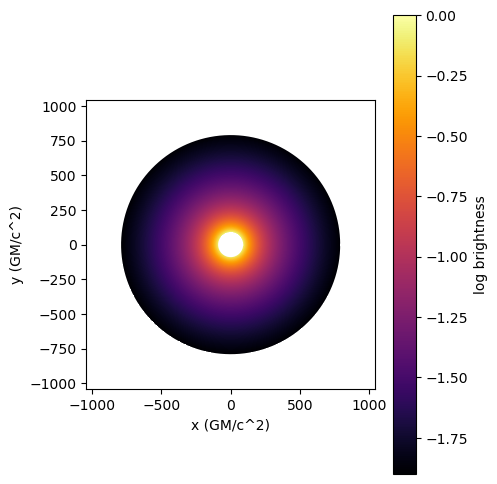

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
PI = 3.14159
TWOPI = 2. * PI
MAXPT = 1000
MAXGRID = 500
MAXCONT = 5
MAXARC = 100
NGSTEP = 100

# Parameters
RIN = 80
ROUT = 800
Q1 = 1.9 
Q2 = 1.9
RBREAK = 500
LOGBRIGHT = 'yes'
AMP = 0
NARMS = 1
AOBS = 150
PITCH = -20 
WIDTH = 40 
RSPIN = RIN
RSPOUT = ROUT

# Convert degrees to radians
AOBS = AOBS * PI / 180.
TANPITCH = np.tan(PITCH * PI / 180.)
SIG = (PI / 180.) * WIDTH / np.sqrt(8. * np.log(2.))
if RSPIN < RIN or RSPIN < 0:
    RSPIN = RIN
if RSPOUT > ROUT or RSPOUT < 0:
    RSPOUT = ROUT
if AOBS >= 0:
    RSPREF = RSPOUT
else:
    RSPREF = RSPIN
    AOBS = -AOBS

# Define plot boundaries
EXTRA = 0.3
XMAX = (1. + EXTRA) * ROUT
XMIN = -XMAX
YMIN = -XMAX
YMAX = XMAX

# Transformation from brightness grid to coordinate space
TRANS = np.array([-XMAX, 2 * XMAX / float(MAXGRID), 0., -XMAX, 0., 2. * XMAX / float(MAXGRID)])

# Brightness grid
BRIGHT = np.zeros((MAXGRID, MAXGRID))
for i in range(MAXGRID):
    for j in range(MAXGRID):
        X = TRANS[0] + TRANS[1] * float(i) + TRANS[2] * float(j)
        Y = TRANS[3] + TRANS[4] * float(i) + TRANS[5] * float(j)
        R = np.sqrt(X**2 + Y**2)
        if R <= RBREAK:
            CNORM = 1
            Q = Q1
        else:
            CNORM = RBREAK**(-Q1 + Q2)
            Q = Q2
        if X != 0:
            if X > 0:
                AZIM = np.arctan(Y / X)
            else:
                AZIM = PI + np.arctan(Y / X)
        elif X == 0 and Y > 0:
            AZIM = PI / 2.
        else:
            AZIM = -PI / 2.
        if R >= RIN and R <= ROUT:
            DISK = CNORM / (R**Q)
            if R >= RSPIN and R <= RSPOUT:
                PSI0 = AOBS + np.log10(R / RSPREF) / TANPITCH
                ARMS = 0.
                for n in range(1, NARMS + 1):
                    PSI = PSI0 + 2. * PI * float(n - 1) / float(NARMS)
                    DPSI = np.abs(AZIM - PSI)
                    ARMS += np.exp(-DPSI**2 / (2. * SIG**2))
                    DPSI = 2. * PI - np.abs(AZIM - PSI)
                    ARMS += np.exp(-DPSI**2 / (2. * SIG**2))
            else:
                ARMS = 0.
            BRIGHT[i, j] = DISK * (1 + 0.5 * AMP * ARMS)
        else:
            BRIGHT[i, j] = 0.

# Normalize the brightness
BMAX = np.max(BRIGHT)
BMIN = np.min(BRIGHT[BRIGHT > 0])  # Only consider non-zero brightness values
BRIGHT[BRIGHT<0]=1e-7
print(f" -> Brightness range: {BMIN:.2e} - {BMAX:.2e}")

if LOGBRIGHT in ['n', 'no']:
    BRIGHT /= BMAX
    BHI = 1.
    BLO = BMIN / BMAX
else:
    BRIGHT = np.log10(BRIGHT / BMAX)
    BHI = 0.
    BLO = np.log10(BMIN / BMAX)

# Generate coordinates for inner and outer ellipses
XIN = np.zeros(MAXPT)
YIN = np.zeros(MAXPT)
XOUT = np.zeros(MAXPT)
YOUT = np.zeros(MAXPT)
for i in range(MAXPT):
    AZIM = 2. * PI * float(i) / float(MAXPT)
    XIN[i] = RIN * np.cos(AZIM)
    YIN[i] = RIN * np.sin(AZIM)
    XOUT[i] = ROUT * np.cos(AZIM)
    YOUT[i] = ROUT * np.sin(AZIM)

# Plot the results
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(XMIN, XMAX)
ax.set_ylim(YMIN, YMAX)

# Plot brightness map
c = ax.imshow(BRIGHT, extent=[XMIN, XMAX, YMIN, YMAX], origin='lower', cmap='inferno')
fig.colorbar(c, ax=ax, label='log brightness')

# Plot the ellipses
ax.plot(XIN, YIN, color='white', lw=2)
ax.plot(XOUT, YOUT, color='white', lw=2)

# Add labels and title
ax.set_xlabel('x (GM/c^2)')
ax.set_ylabel('y (GM/c^2)')
#ax.set_title('Spiral Disk with Arms')
fig.tight_layout()
plt.savefig('E2pic.png')